# <font color='steelblue'> Time inside choice point during test runs analysis <font>
### In this notebook I will analyze the time the rats spent inside the choice point square during test runs and compare within and across each experimental group and stimulation condition.
### The time spent inside this ROI will be used as a proxy of delayed choice: a higher time spent in this ROI suggests that the rat is delaying the expression of its choice.
    
### If the cingulate cortex is involved in computations leading to the expression of choice, we hypothesize that the time inside the choice point square during the test illumination condition will be higher in NpHR+ rats when compared to the same condition in NPHR- rats or Non-illuminated periods in both. This increased latency could be a behavioral output of delayed or perturbed choice.
    
### We will also consider the sample illuminated test runs in this analysis, in order to understand whether illuminating the sample run in NpHR+ rats could also lead to time changes during the following test run, when compared with the Non-illuminated test runs or sample illumination in the NpHR- rats.
    

## <font color='firebrick'> Imports

***

In [107]:
#Modules
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from file_lists import get_file_list

%run data_prep_functions.ipynb
%matplotlib inline

## <font color='firebrick'> Inputs

***

In [2]:
path = "E:\POSITION DATA\PRE PROCESSED"

## <font color= 'seagreen'> Collect the pruned timestamped position and CP rois from all rats in the given path

Text(0, 0.5, 'N data points')

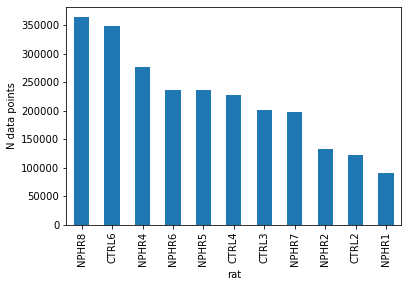

In [3]:
data, rois = collect_pruned_position_and_cp_rois_all_rats_in_path(path)

# Check if data from all rats are present in the dataframe
data['rat'].value_counts().plot.bar()
plt.xlabel('rat')
plt.ylabel('N data points')

## <font color= 'seagreen'> Retrieve the test runs only

In [4]:
test_runs_raw = data[data['run_type']=='T']
test_runs_raw.head(3)

,session,run_nr,timestamp,x,y,x_diff,run_type,stim_condition,outcome,rat,group
466,2020-07-28T12_53_43,2.0,110.909210,38.24630,75.44260,-161.688702,T,-1.0,0.0,NPHR5,NPHR
467,2020-07-28T12_53_43,2.0,110.942144,38.95508,76.16232,0.708780,T,-1.0,0.0,NPHR5,NPHR
468,2020-07-28T12_53_43,2.0,110.974566,39.29630,76.92740,0.341220,T,-1.0,0.0,NPHR5,NPHR


## <font color='seagreen'> Get ROI crossing timestamps: start of run, entry in cp, exit of cp

In [7]:
test_runs = get_roi_crossing_timestamps_for_runs_in_df(test_runs_raw, rois)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1.0,1.0,NPHR,371.569088,372.640947
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3.0,1.0,NPHR,755.435469,756.431386
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3.0,0.0,NPHR,957.866982,958.900954


##### the original ROI (no increases) removes ~ 23% of the number of test runs (kept 3252 runs out of 4826). This means that in these runs we did not find datapoints inside the original ROI. This is possibly due to the fact that the led is not directly on top of the rat's head but in the patch cable. This leads to some distortion of the osition data e regards to the maze landmarks. I will increase the ROI by 5 cm in order to include this distortion ( I chose 5 cm arbitrarily, although it corresponds to about half the width/height of the ROI). 
#### Increasing the ROI by 10 cm in each side will only remove 2 runs . A visual confirmation of the session data overlayed with the datapoints inside the CP ROI confirms that they successfully capture the bifucation point (the CP ROI). i will proceed to use this ROI. 

## <font color= 'seagreen'> Calculate time spent inside ROI

In [8]:
test_runs['time_spent']=test_runs['cp_exit_timestamp']-test_runs['cp_entry_timestamp']

In [9]:
test_runs.head()

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,time_spent
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1.0,1.0,NPHR,371.569088,372.640947,1.071859
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3.0,1.0,NPHR,755.435469,756.431386,0.995917
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3.0,0.0,NPHR,957.866982,958.900954,1.033971
3,2019-08-08T12_41_07,NPHR1,16.0,1018.530202,T,0.0,1.0,NPHR,1045.142451,1046.004096,0.861645
4,2019-08-08T12_41_07,NPHR1,18.0,1151.446016,T,0.0,1.0,NPHR,1153.832614,1154.563149,0.730534


In [18]:
# Calculate latency to CP exit and remove runs with latency to CP exit below 15 seconds (partial CG illumination)
test_runs['latency_to_cp_exit'] = test_runs['cp_exit_timestamp'] - test_runs['start_timestamp']
below15 = test_runs[test_runs['latency_to_cp_exit']< 15]

In [19]:
# Times spend in ROI below 0 seconds should not exist!
below15[below15['time_spent']<=0].count()

session               0
rat                   0
run_nr                0
start_timestamp       0
run_type              0
stim_condition        0
outcome               0
group                 0
cp_entry_timestamp    0
cp_exit_timestamp     0
time_spent            0
latency_to_cp_exit    0
dtype: int64

## <font color= 'seagreen'> Remove Pre-stimulation runs 

In [20]:
below15=below15[test_runs_below15['stim_condition'] != -1]
below15['stim_condition'] =  below15['stim_condition'].astype(str)

***
## <font color = 'darkgreen'> 1. Distribution of time spent inside the choie point (as defined by ROI+10 cm) 
***

In [21]:
counts = below15.groupby(['group','stim_condition'])['time_spent'].count()
counts

group  stim_condition
CTRL   0.0               520
       1.0               394
       3.0               517
NPHR   0.0               789
       1.0               757
       3.0               740
Name: time_spent, dtype: int64

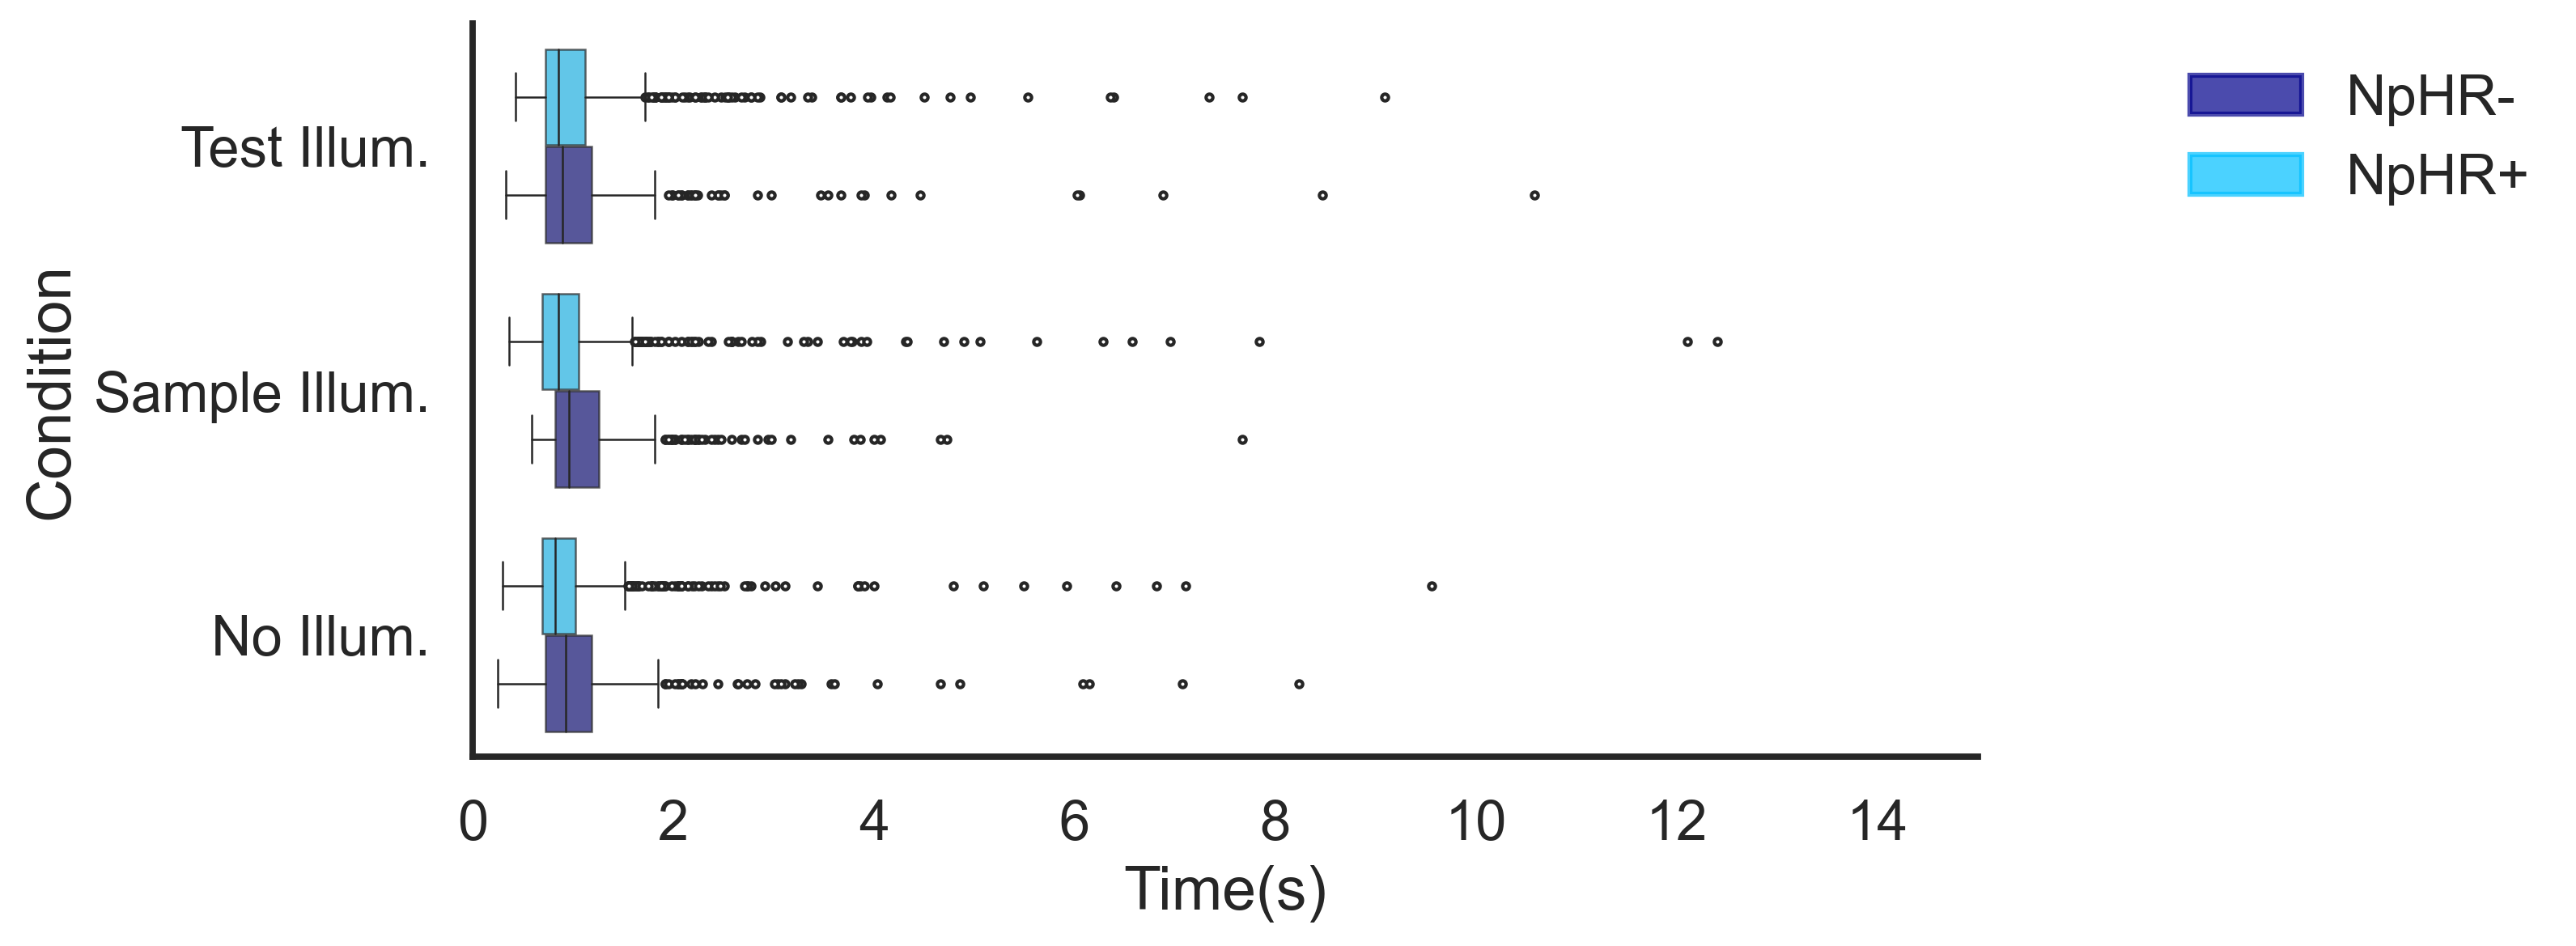

In [108]:
boxplot_time_distributions_within_condition(below15, 'time_spent', [0,15])
ctrl_pbatch = mpatches.Patch(color='navy', label='NpHR-', alpha=.7)
nphr_patch = mpatches.Patch(color='deepskyblue', label='NpHR+', alpha=.7)
plt.legend(handles=[ctrl_patch, nphr_patch], frameon=False, loc='upper right',bbox_to_anchor=(1.4, 1))

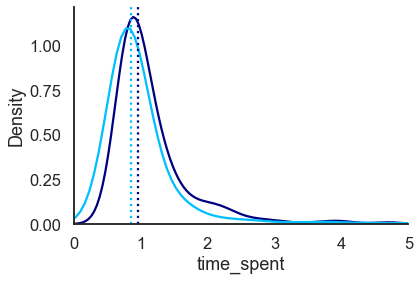

In [47]:
sample_stim = below15[below15['stim_condition']=='1.0']
ctrl_sample = sample_stim[sample_stim['group']=='CTRL']
nphr_sample = sample_stim[sample_stim['group']=='NPHR']

sns.kdeplot(data=ctrl_sample, x='time_spent', color='navy')
sns.kdeplot(data=nphr_sample, x='time_spent', color='deepskyblue')
plt.axvline(ctrl_sample['time_spent'].median(), c='navy', linestyle='dotted')
plt.axvline(nphr_sample['time_spent'].median(), c='deepskyblue', linestyle='dotted')

plt.xlim([0,5])
sns.despine()

In [51]:
quantiles = calculate_quantiles(below15, ['group', 'stim_condition'], 'time_spent')

(0.0, 2.0)

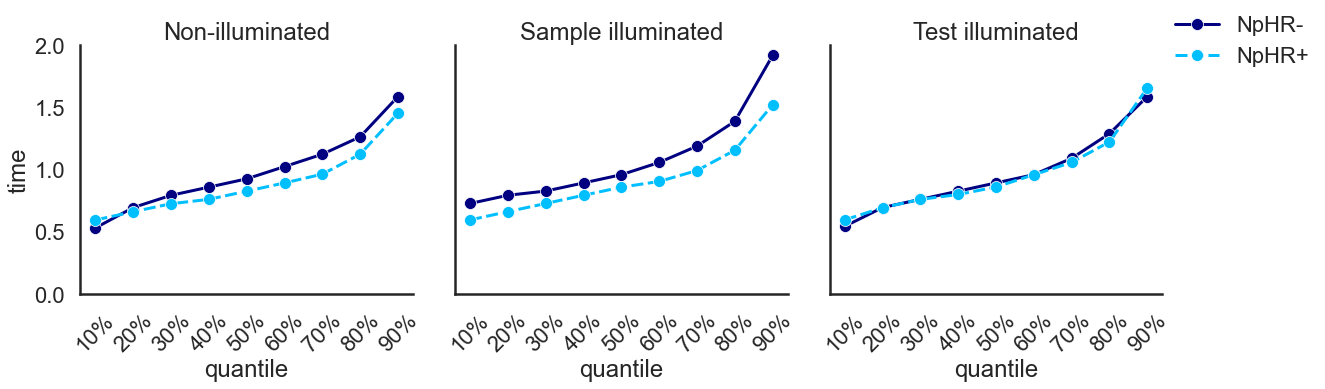

In [52]:
plot_quantile_curves_within_condition(quantiles)
plt.ylim([0,2])

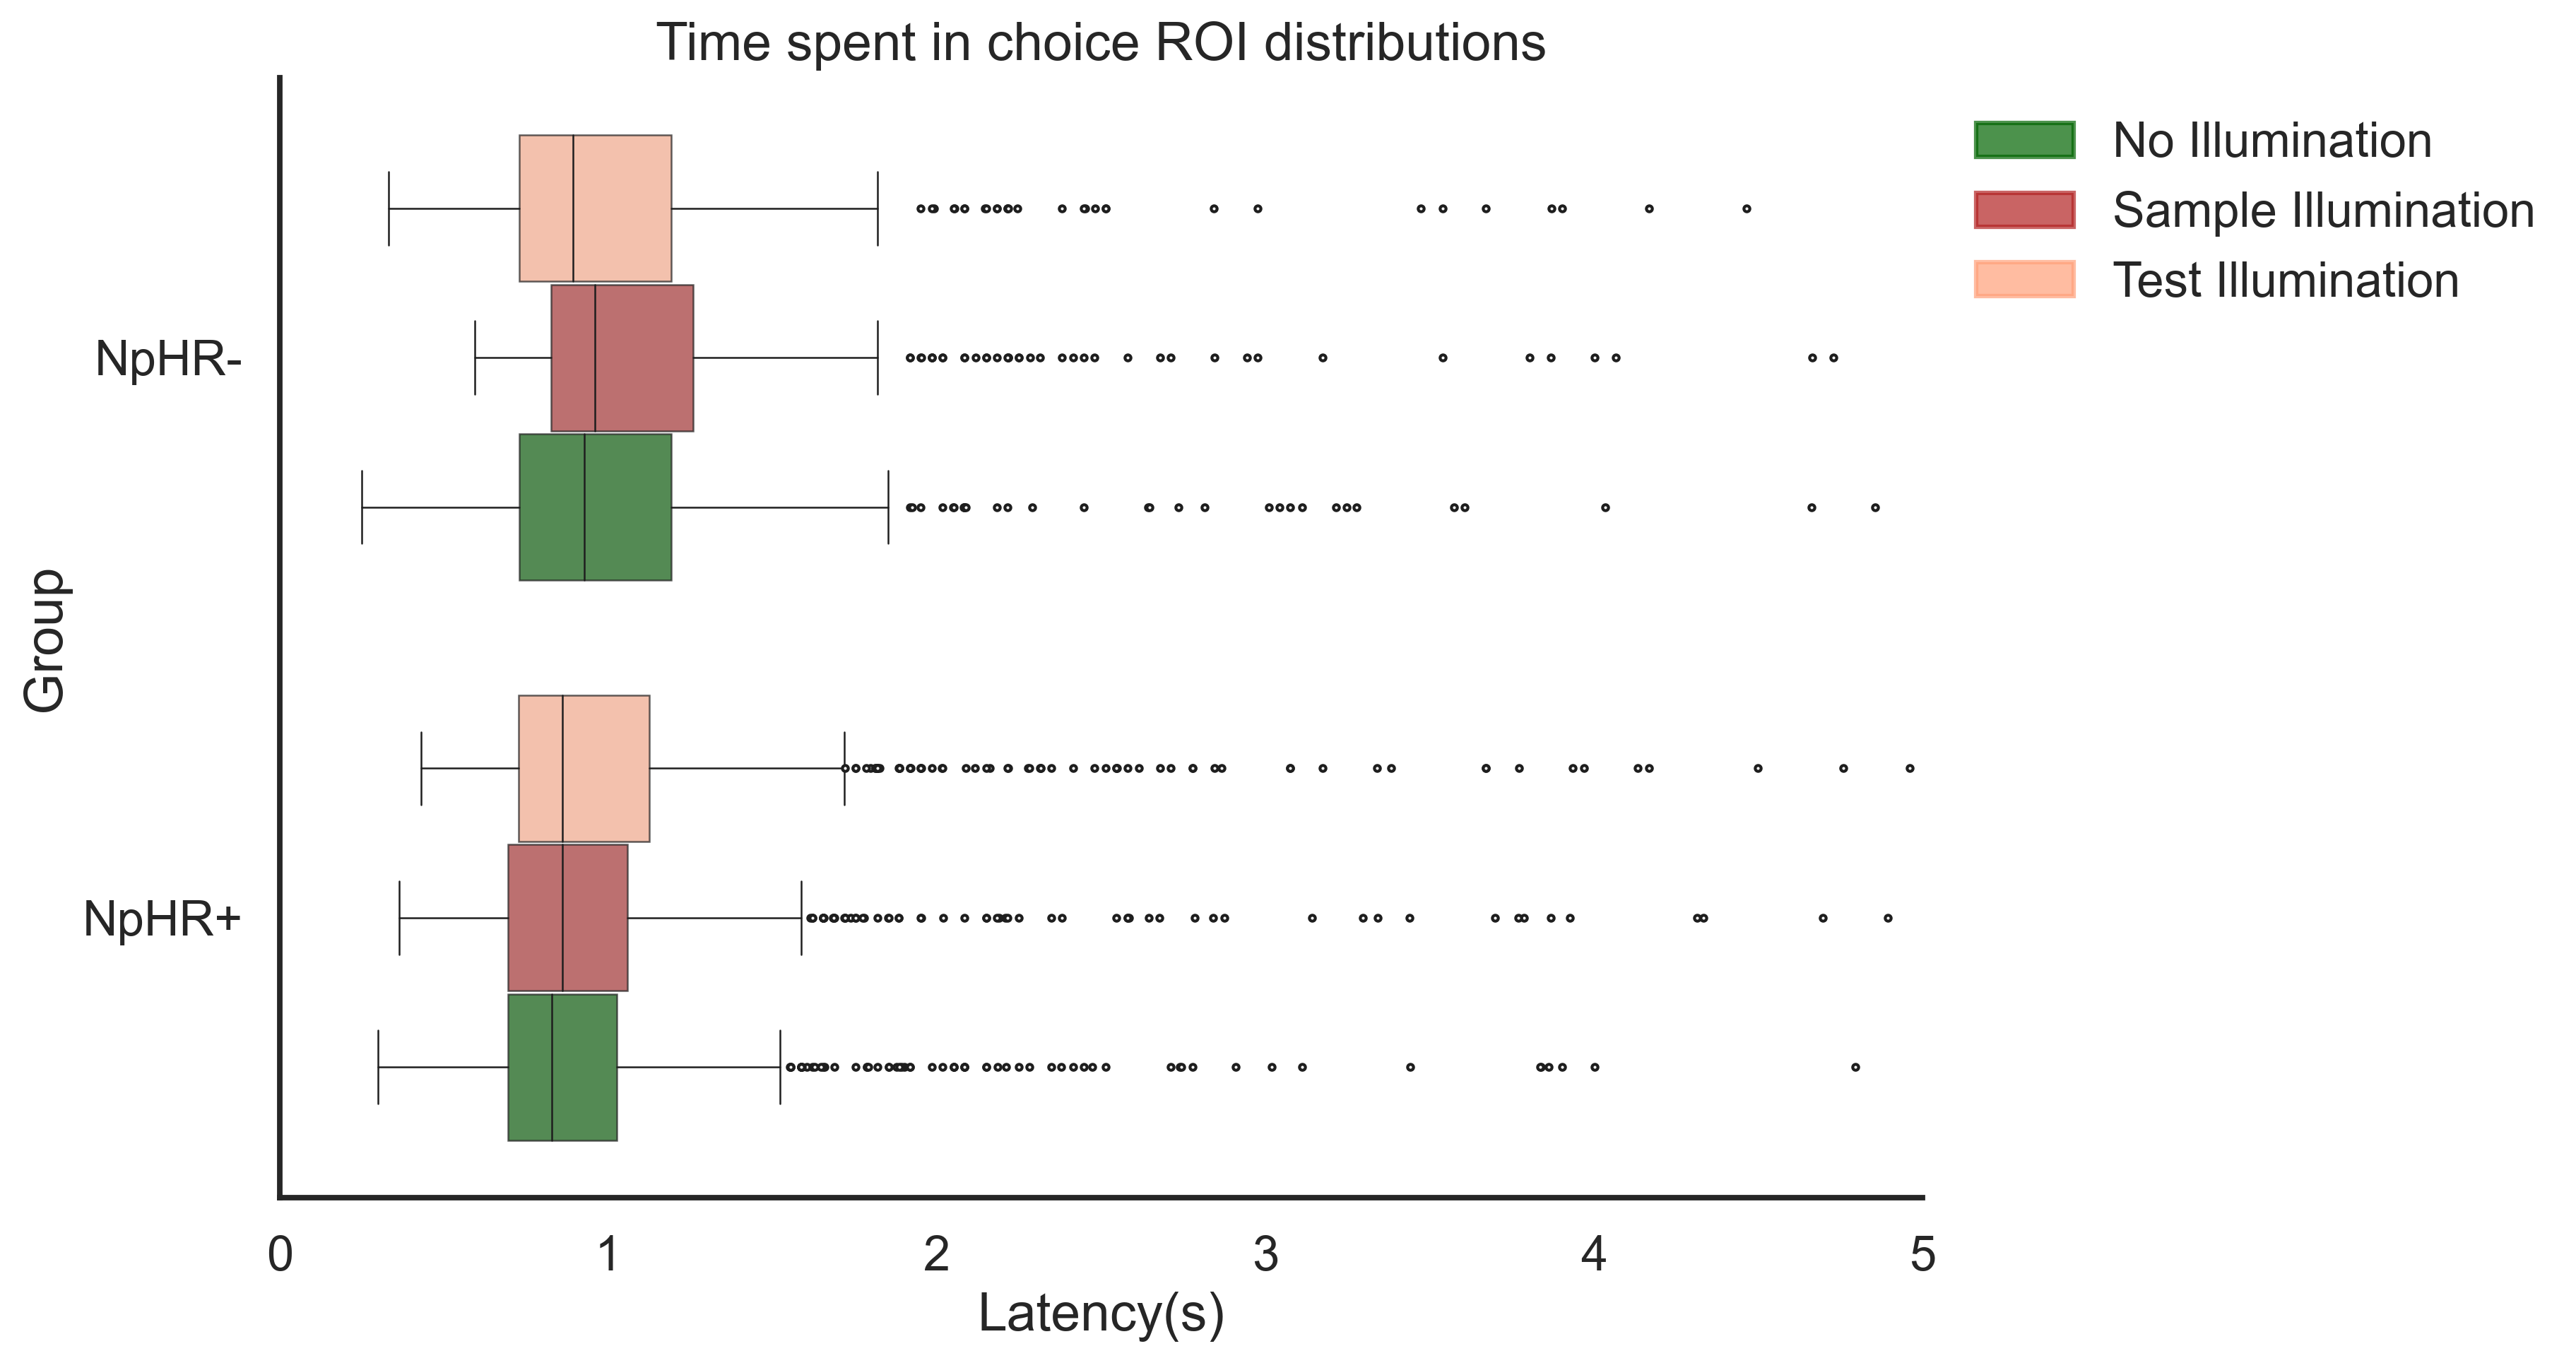

In [69]:
boxplot_time_distributions_within_groups(below15, 'time_spent', [0,5])
no_patch = mpatches.Patch(color='darkgreen', label='No Illumination', alpha=.7)
sample_patch = mpatches.Patch(color='firebrick', label='Sample Illumination', alpha=.7)
test_patch = mpatches.Patch(color='lightsalmon', label='Test Illumination', alpha=.7)
plt.title('Time spent in choice ROI distributions')
plt.legend(handles=[no_patch, sample_patch, test_patch], 
           frameon=False, loc='upper right', bbox_to_anchor=(1.4, 1))

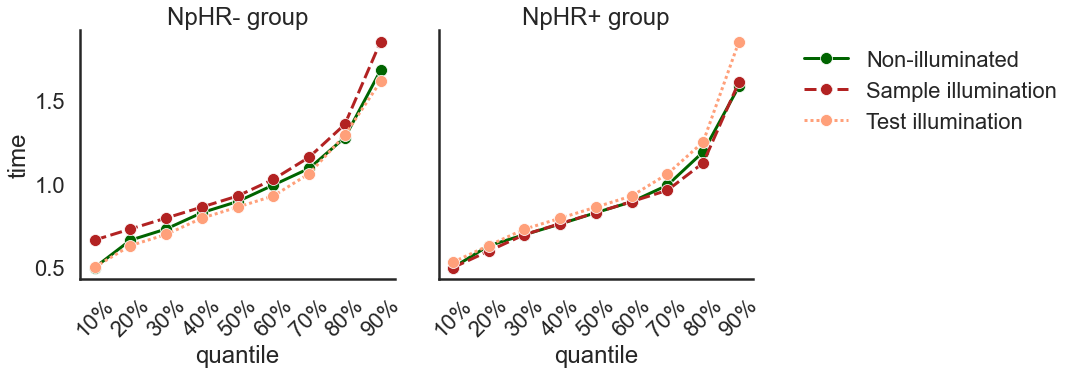

In [20]:
plot_quantile_curves_within_group(quantiles)

## <font color='darkgreen'> Time spend inside CP ROI in error trials 

In [114]:
errors = below15[below15['outcome']==0]
errors.groupby(['group', 'stim_condition'])['time_spent'].count()

group  stim_condition
CTRL   0.0               104
       1.0                83
       3.0               124
NPHR   0.0               138
       1.0               124
       3.0               162
Name: time_spent, dtype: int64

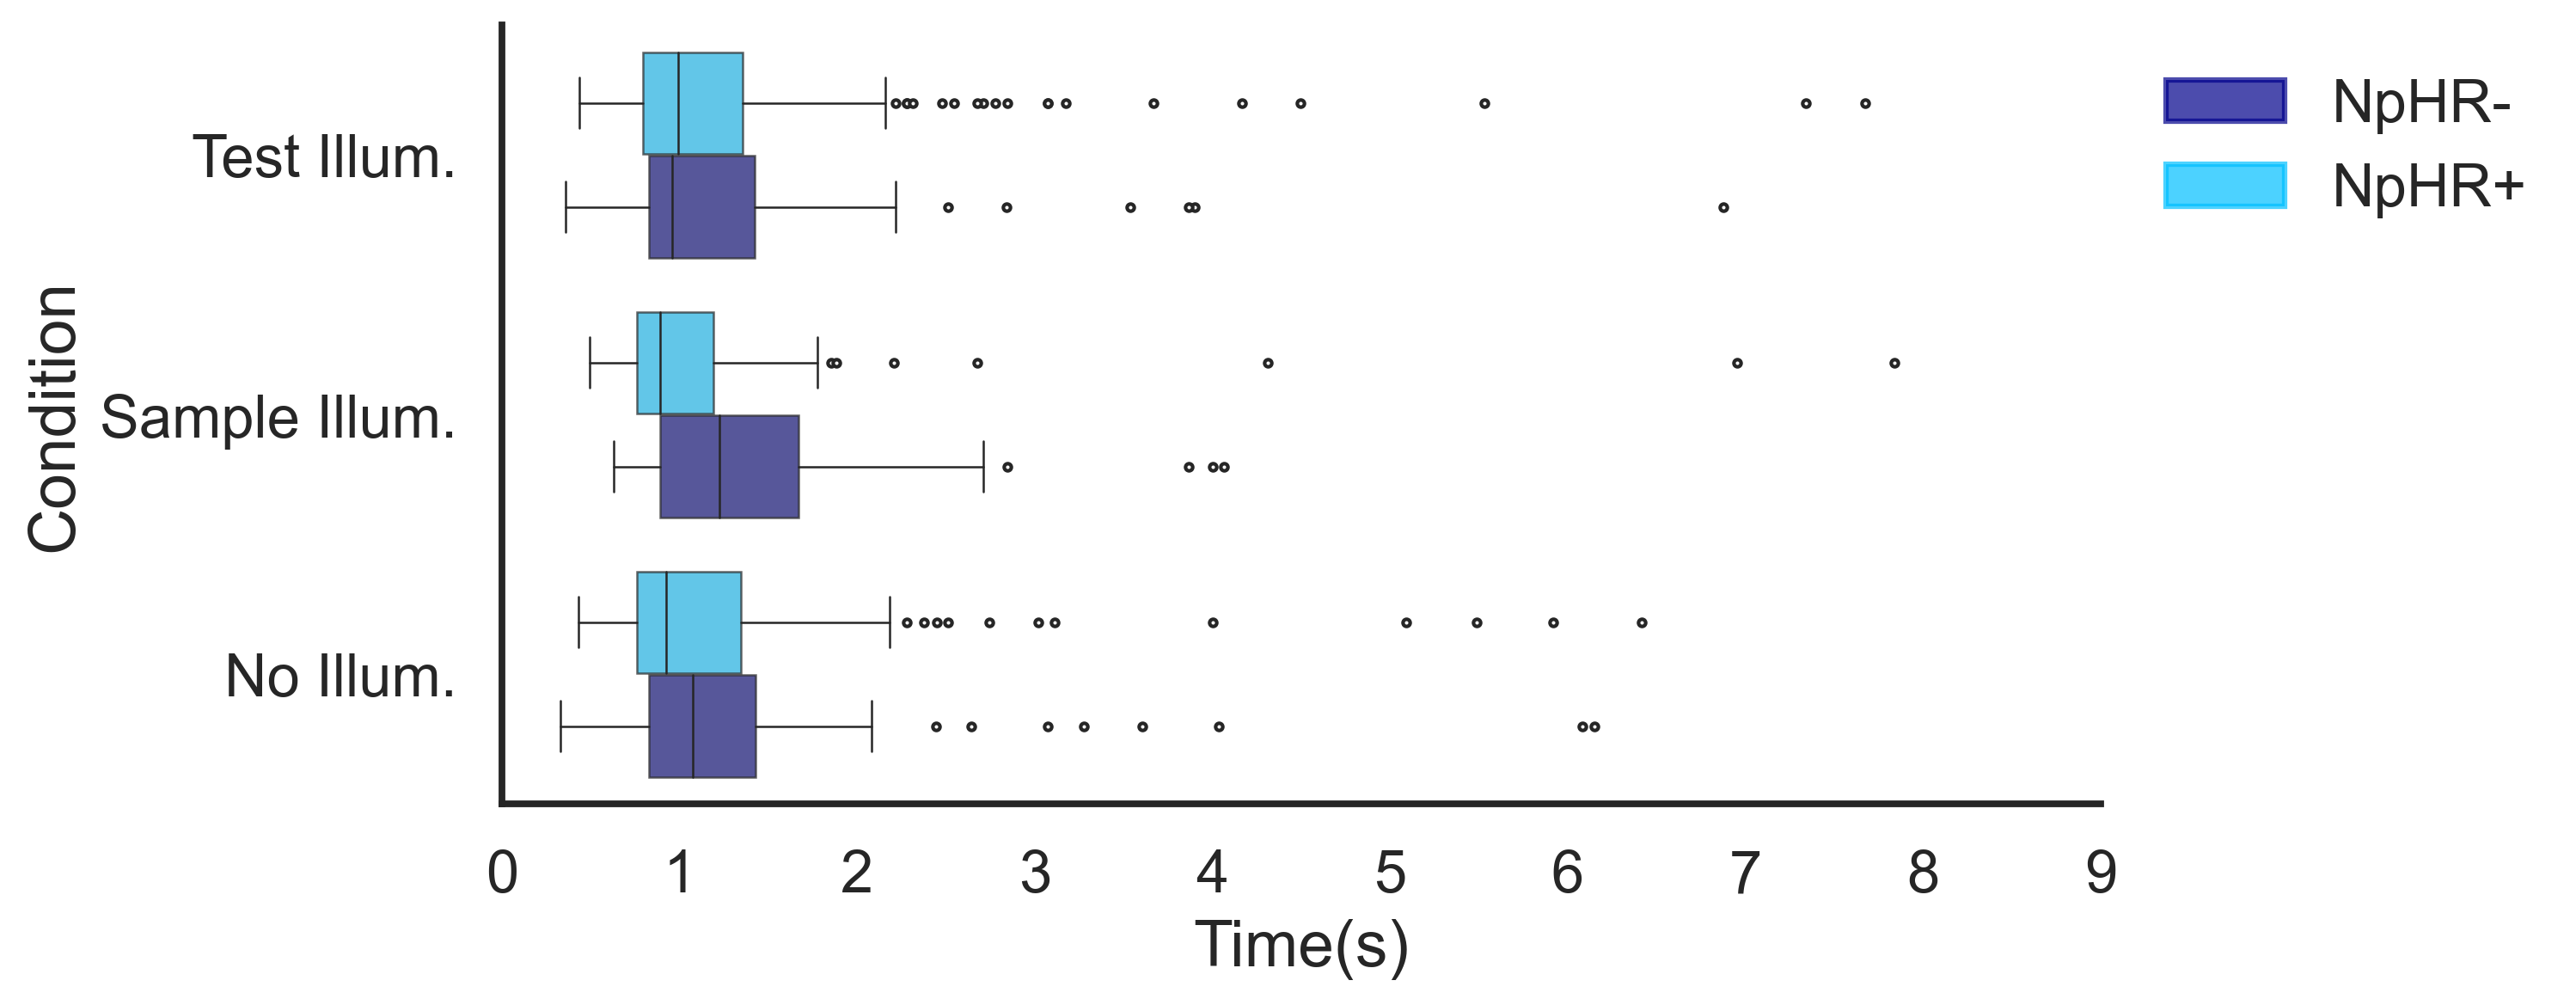

In [112]:
boxplot_time_distributions_within_condition(errors, 'time_spent', [0, 9])
plt.legend(handles=[ctrl_patch, nphr_patch], frameon=False, loc='upper right',bbox_to_anchor=(1.3, 1))

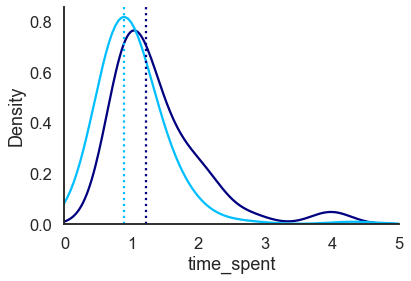

In [113]:
sample_stim = errors[errors['stim_condition']=='1.0']
ctrl_sample = sample_stim[sample_stim['group']=='CTRL']
nphr_sample = sample_stim[sample_stim['group']=='NPHR']
sns.kdeplot(data=ctrl_sample, x='time_spent', color='navy')
sns.kdeplot(data=nphr_sample, x='time_spent', color='deepskyblue')
plt.axvline(ctrl_sample['time_spent'].median(), c='navy', linestyle='dotted')
plt.axvline(nphr_sample['time_spent'].median(), c='deepskyblue', linestyle='dotted')
plt.xlim([0,5])
sns.despine()

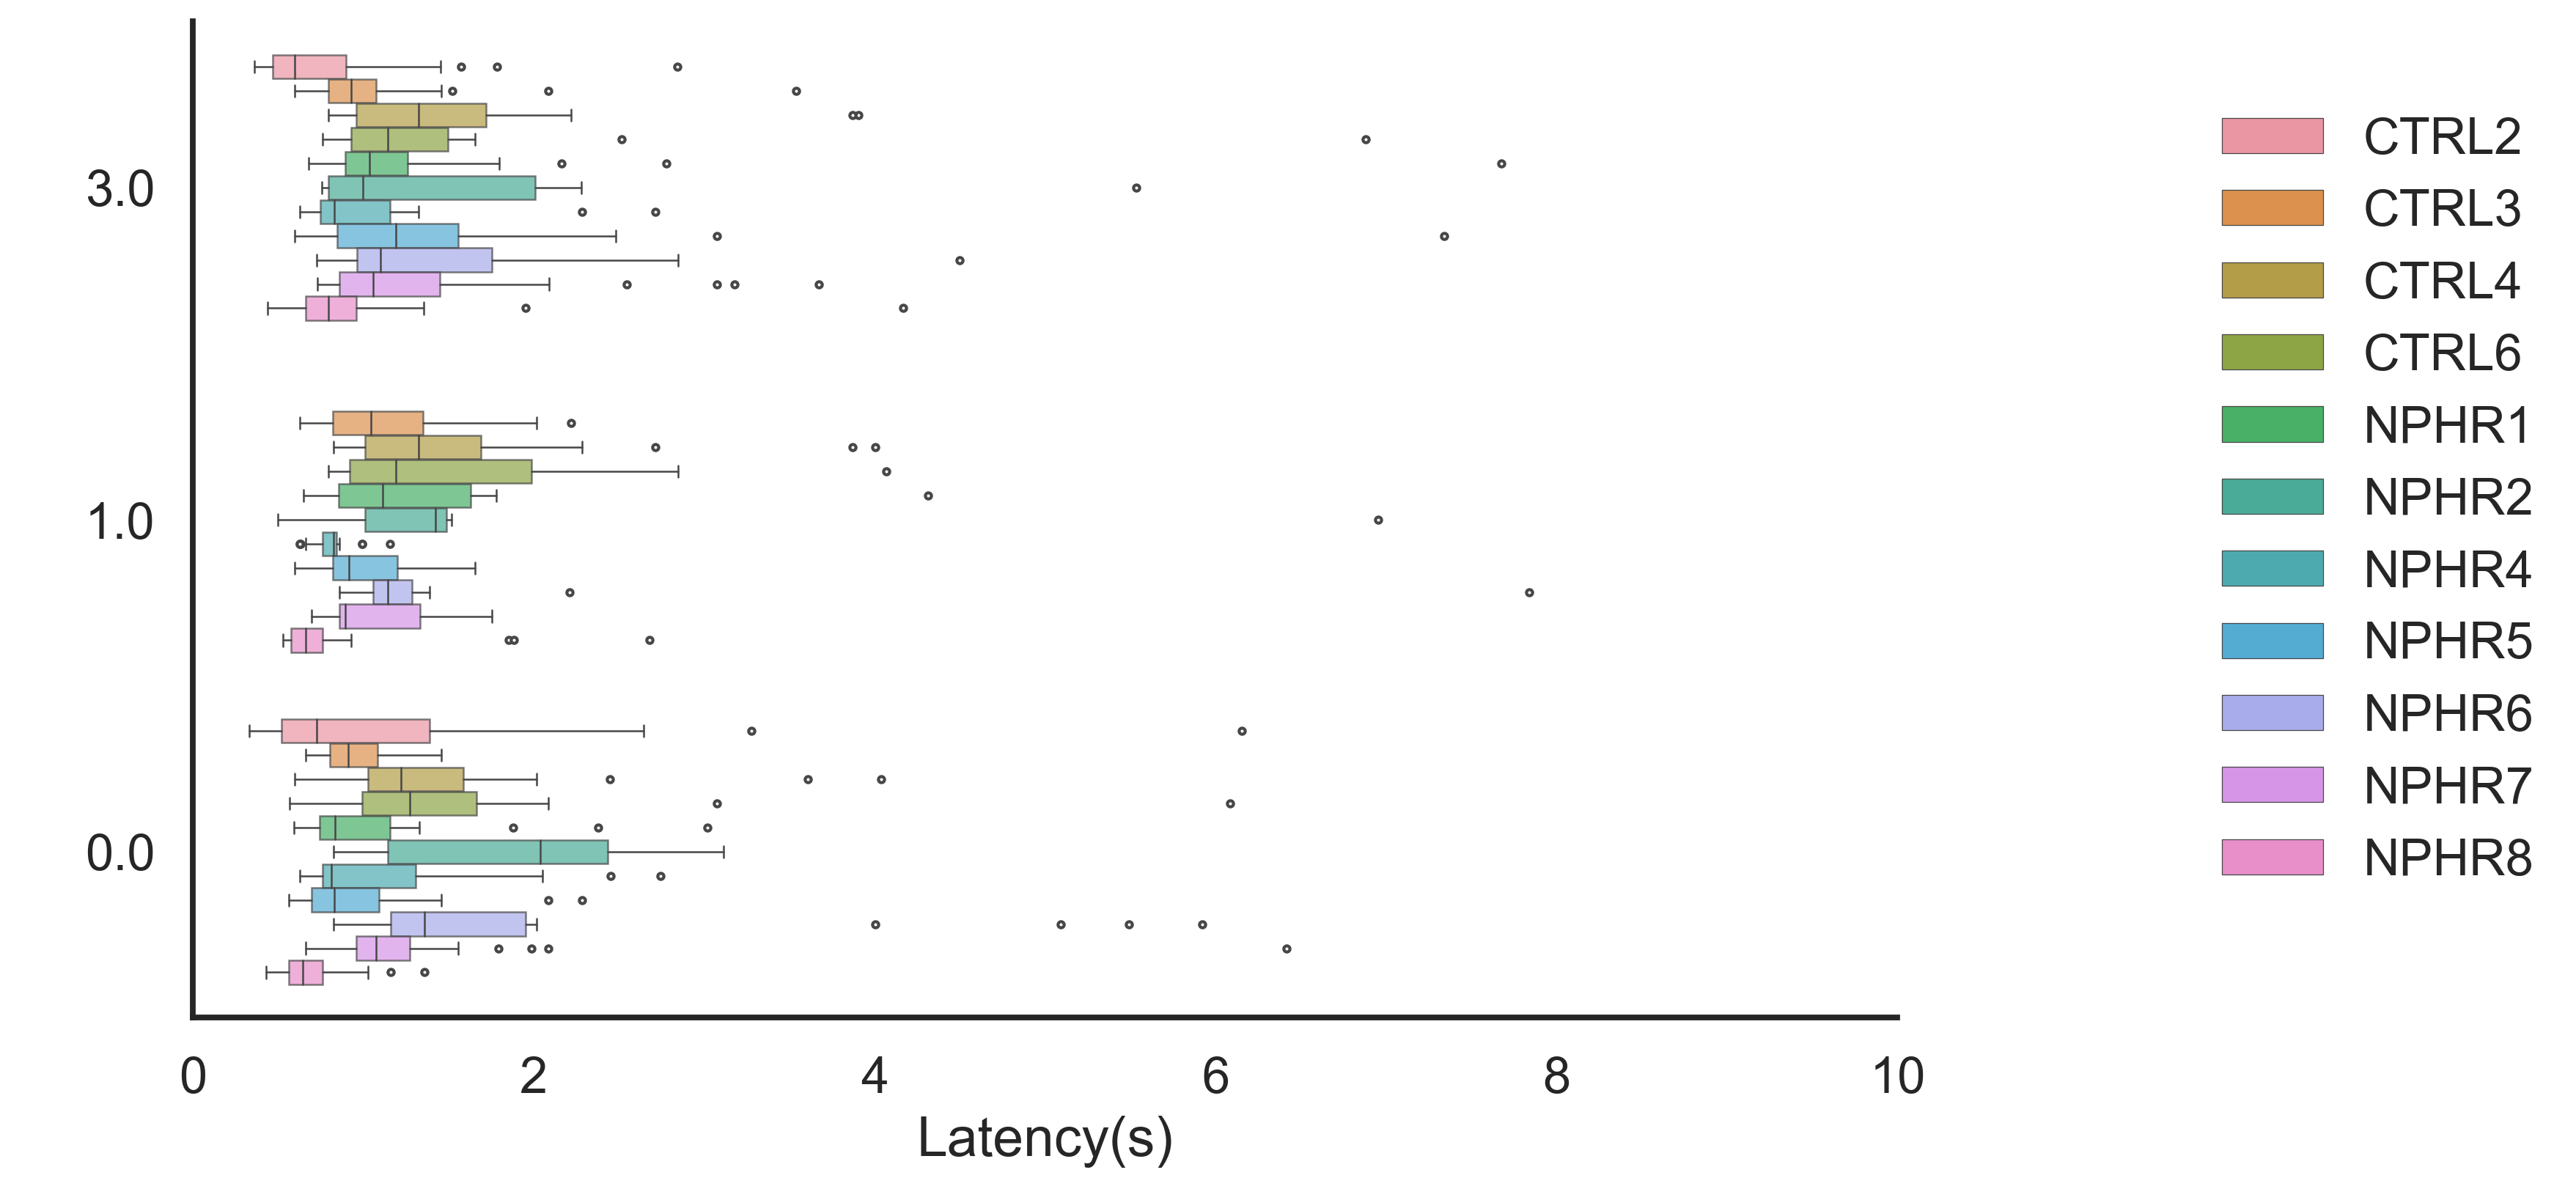

In [115]:
sns.set(style="white", context='talk')
plt.figure(figsize=(10,6), dpi=300)

flierprops=dict(marker='o', markerfacecolor='white', markersize=2, linewidth=.2)
a = sns.boxplot(
    data=errors, x='time_spent',y='stim_condition',hue='rat',
    linewidth=.6, flierprops=flierprops, boxprops=dict(alpha=.7), 
    hue_order=['CTRL2','CTRL3', 'CTRL4', 'CTRL6', 'NPHR1', 'NPHR2', 'NPHR4', 'NPHR5', 'NPHR6', 'NPHR7', 'NPHR8' ]
)
plt.xlabel('Latency(s)')
plt.ylabel(' ')
plt.xlim([0, 10])
plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.4, .95))
sns.despine()

#### The absence of CTRL2 data for the Sample illumination could be driving this difference between groups: 
####  FIrstly because he is one of the fastest rats. Secondly, because of the lower number of animals in the control group. 

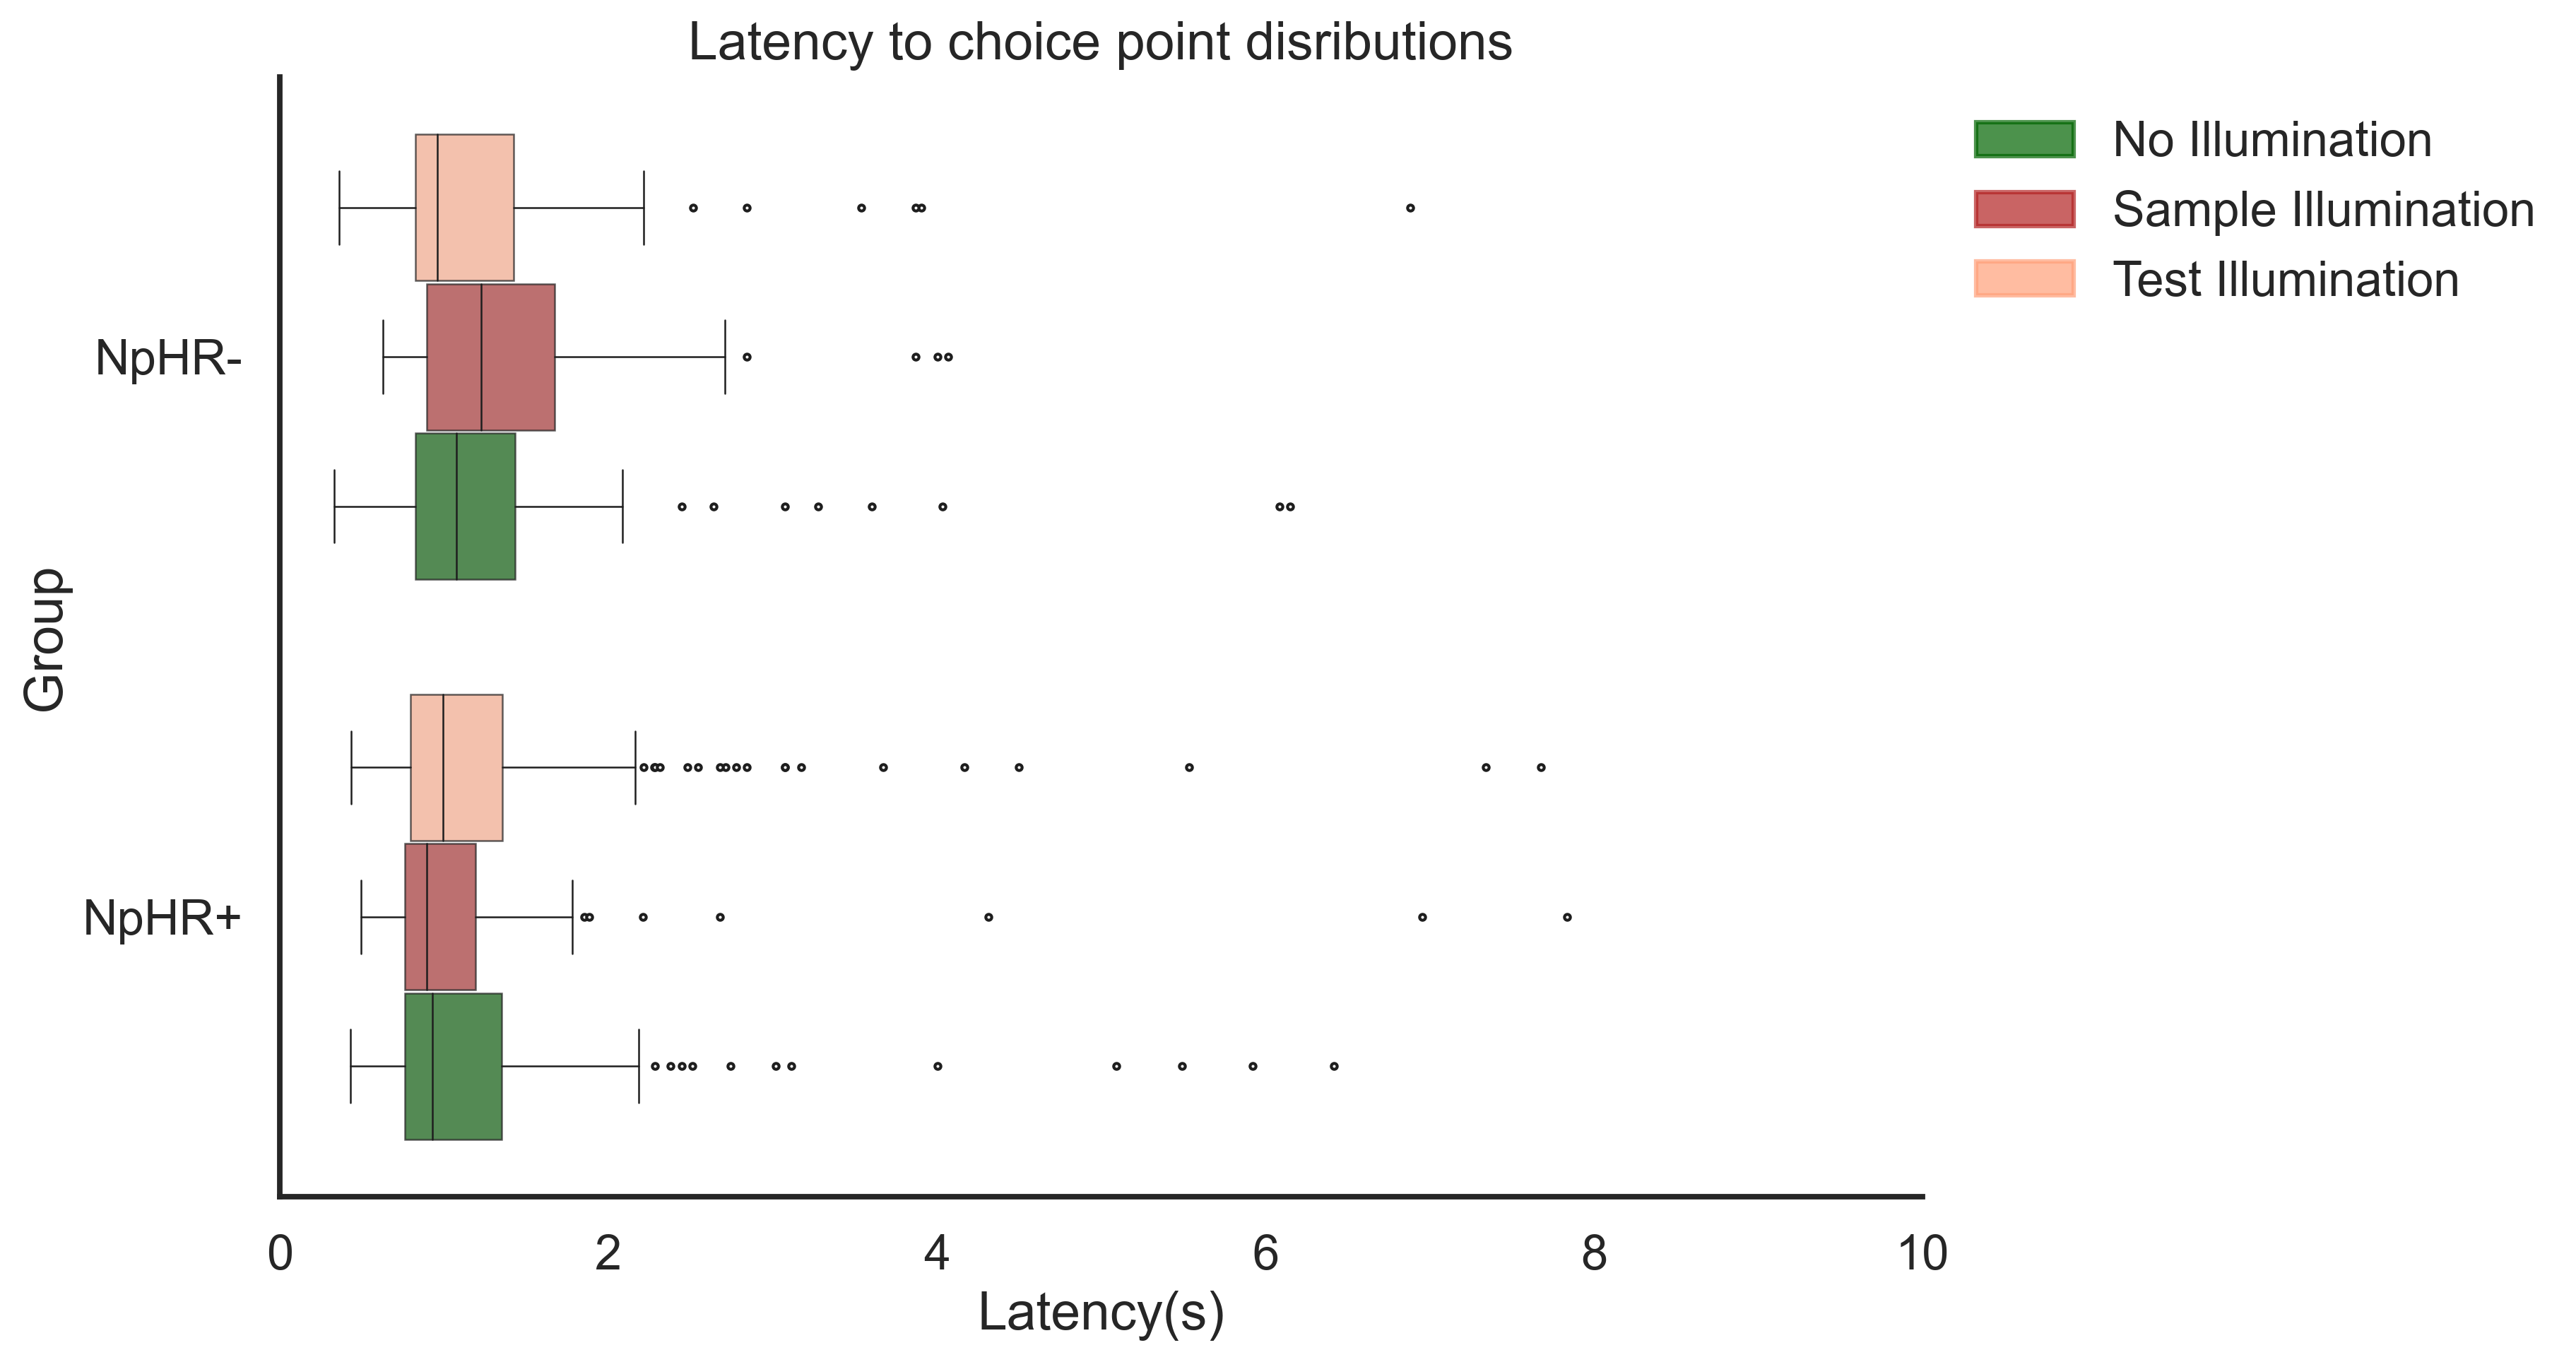

In [111]:
boxplot_time_distributions_within_groups(errors, 'time_spent', [0,10])
plt.legend(handles=[no_patch, sample_patch, test_patch], 
           frameon=False, loc='upper right', bbox_to_anchor=(1.4, 1))

***
## <font color = 'darkgreen'> 3. Distribution of time spent inside the choie point (as defined by ROI+10 cm) only for the first 10 trials of each condition
***

In [116]:
firsts = test_runs.groupby(['rat', 'stim_condition']).head(10)
firsts = firsts[firsts['latency_to_cp_exit']<15]
#firsts.groupby(['rat', 'stim_condition'])['time_spent'].count()

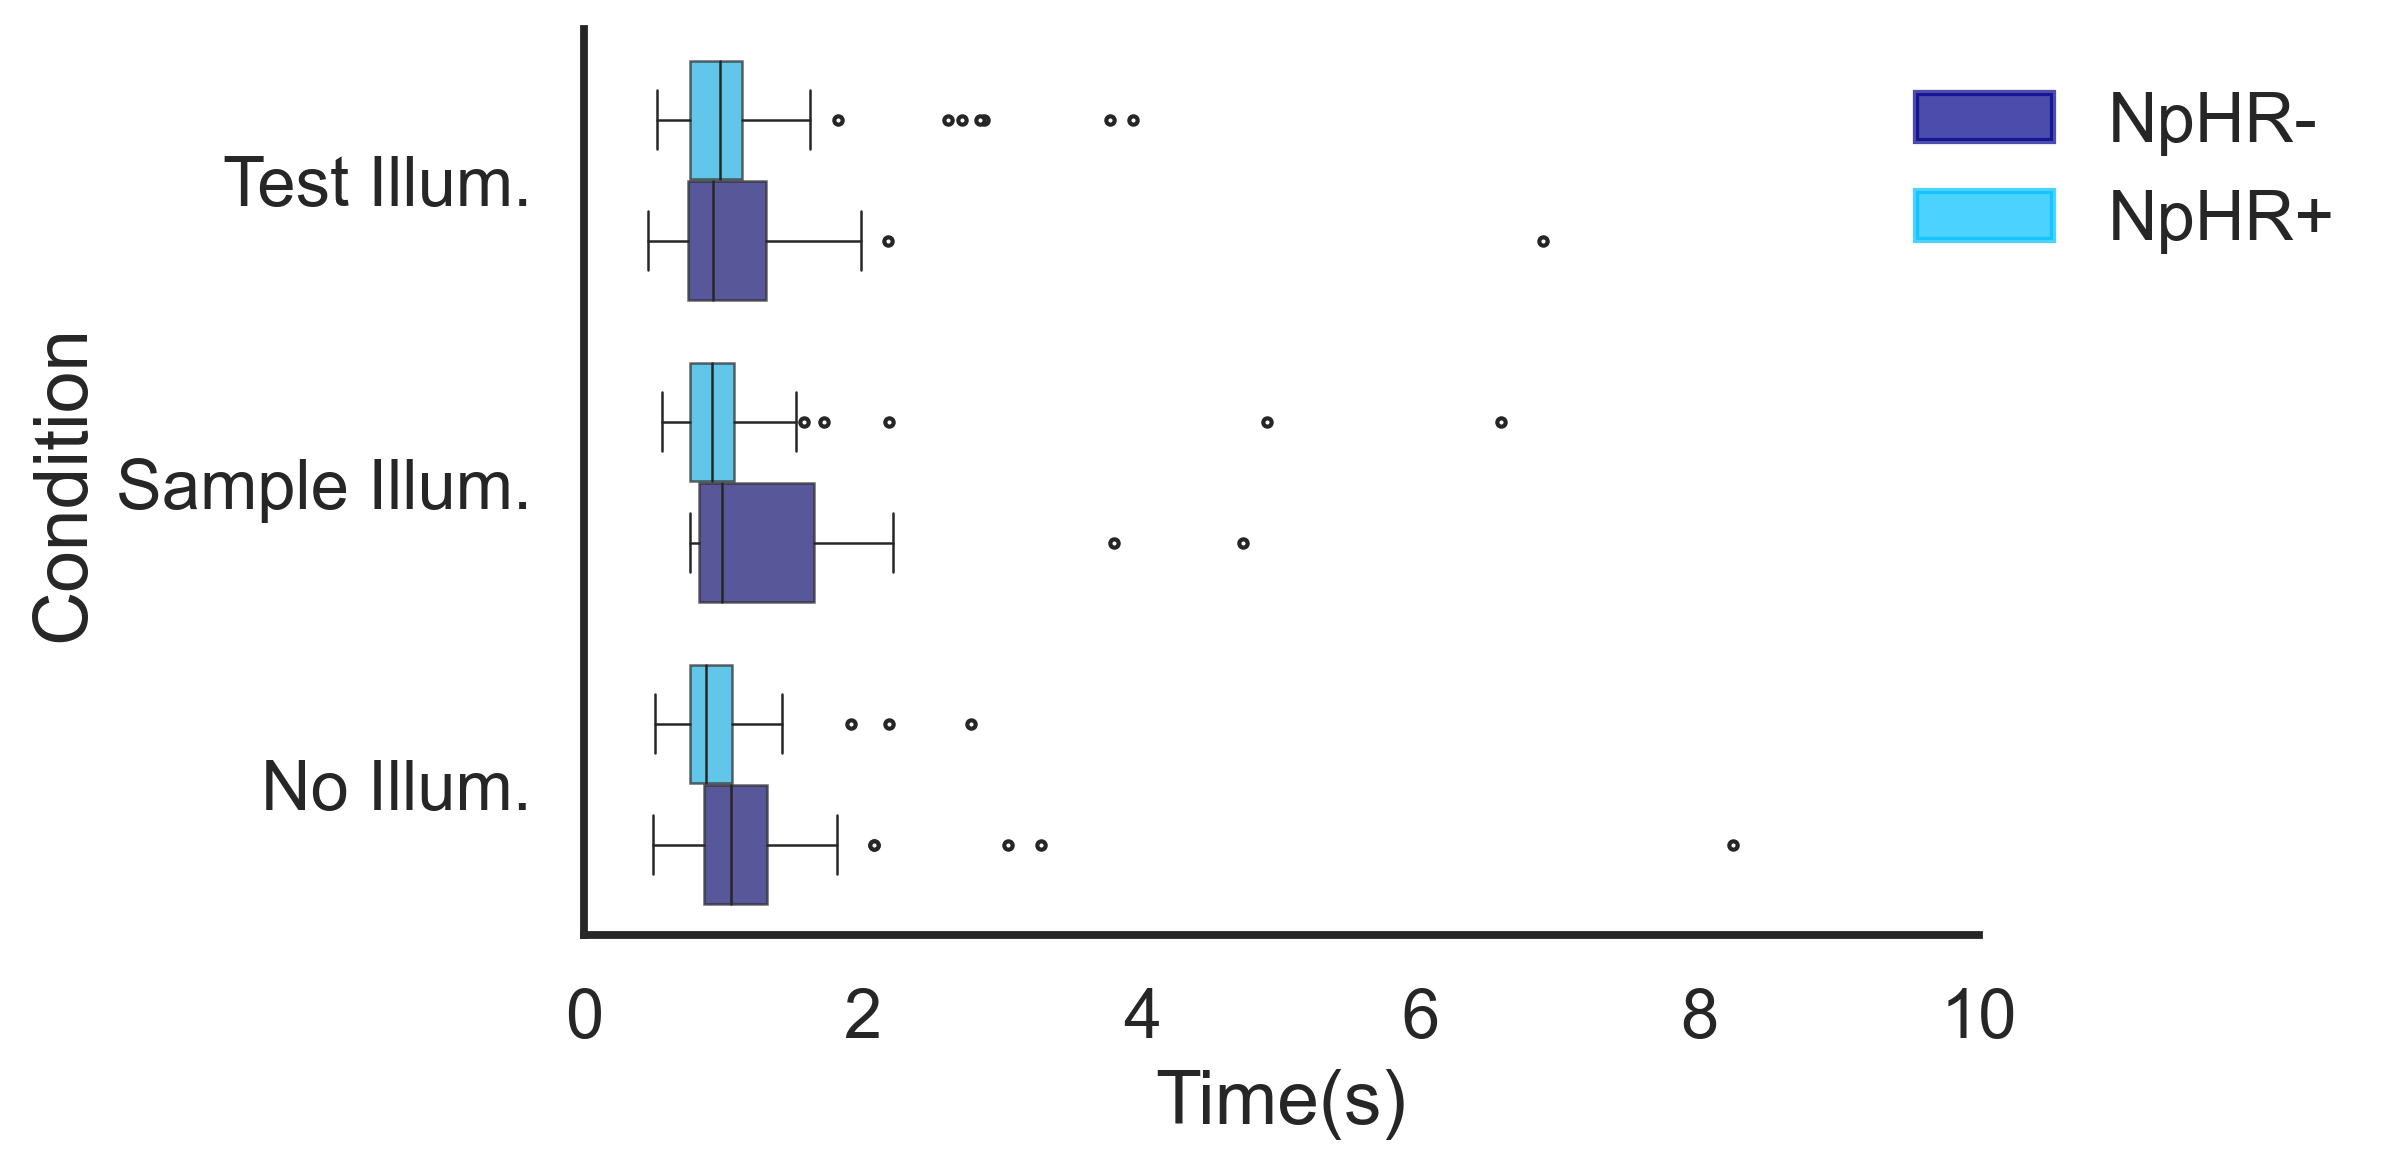

In [81]:
boxplot_time_distributions_within_condition(firsts, 'time_spent', [0, 10])
plt.legend(handles=[ctrl_patch, nphr_patch], frameon=False, loc='upper right',bbox_to_anchor=(1.3, 1))plt.legend(handles=[ctrl_patch, nphr_patch], frameon=False, loc='upper right',bbox_to_anchor=(1.3, 1))

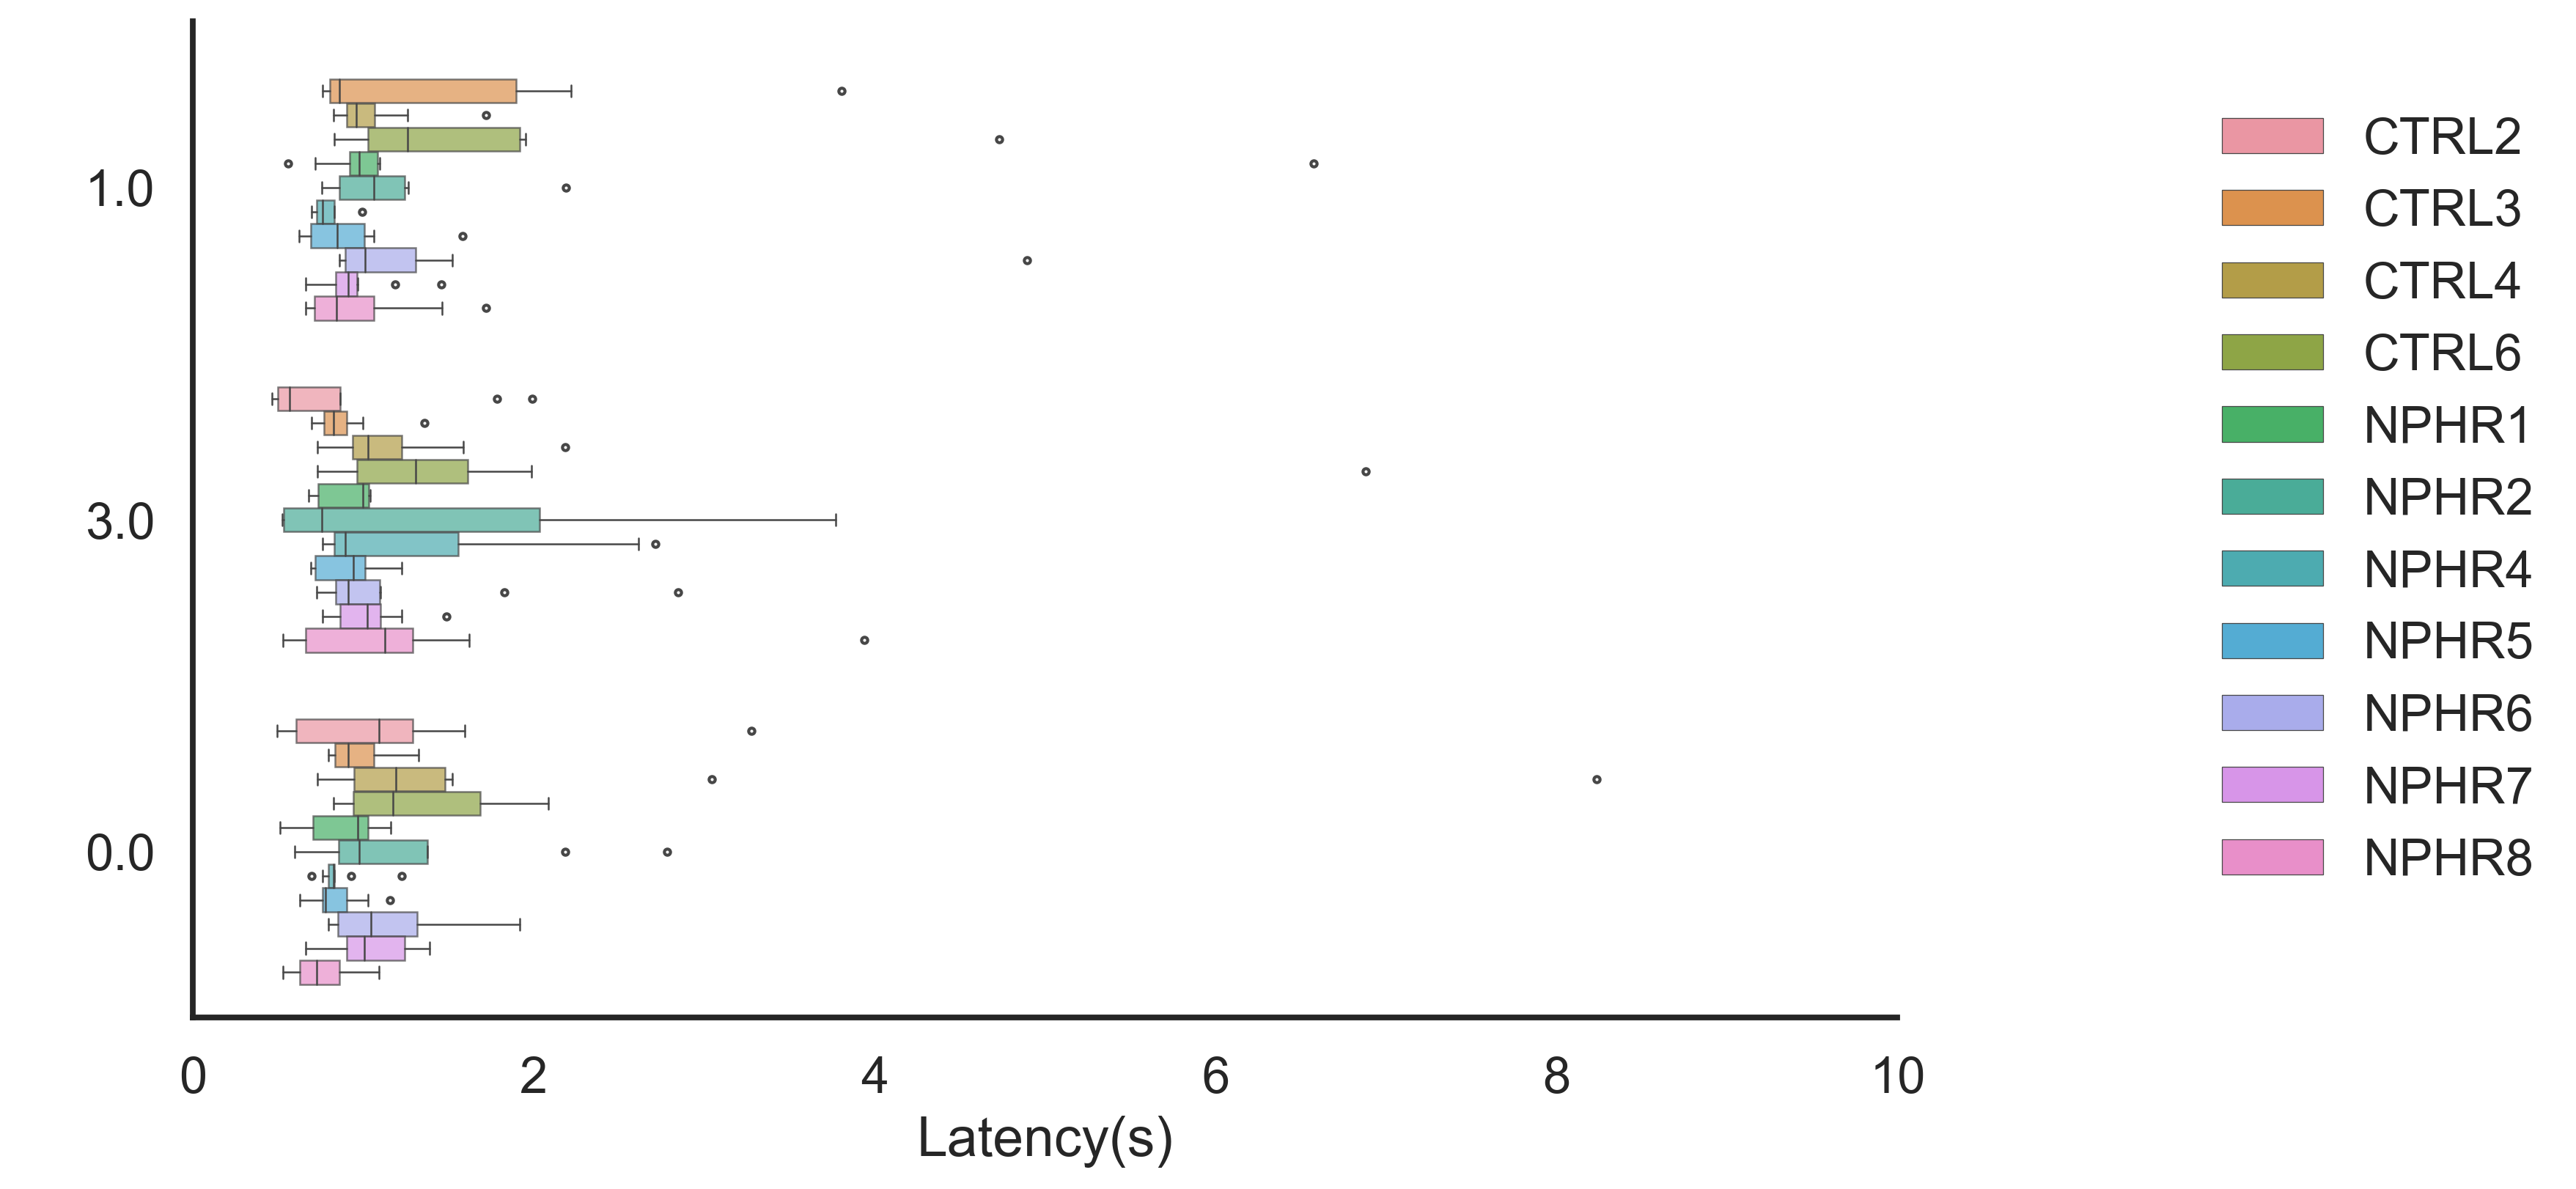

In [117]:
sns.set(style="white", context='talk')
plt.figure(figsize=(10,6), dpi=300)

flierprops=dict(marker='o', markerfacecolor='white', markersize=2, linewidth=.2)
a = sns.boxplot(
    data=firsts, x='time_spent',y='stim_condition',hue='rat',
    linewidth=.6, flierprops=flierprops, boxprops=dict(alpha=.7), 
    hue_order=['CTRL2','CTRL3', 'CTRL4', 'CTRL6', 'NPHR1', 'NPHR2', 'NPHR4', 'NPHR5', 'NPHR6', 'NPHR7', 'NPHR8' ]
)
plt.xlabel('Latency(s)')
plt.ylabel(' ')
plt.xlim([0, 10])
plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.4, .95))
sns.despine()

In [82]:
firsts_quantiles = calculate_quantiles(firsts, ['group', 'stim_condition'], 'time_spent')

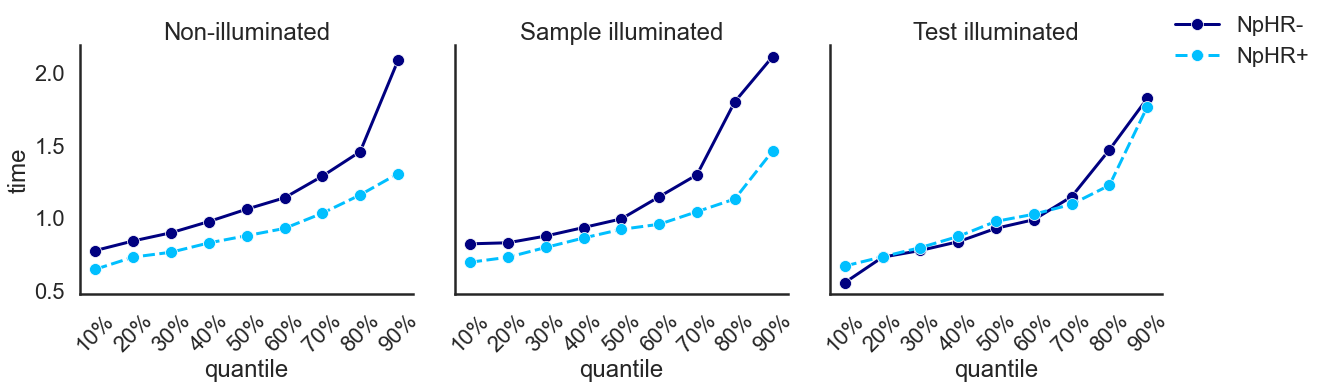

In [83]:
plot_quantile_curves_within_condition(firsts_quantiles)

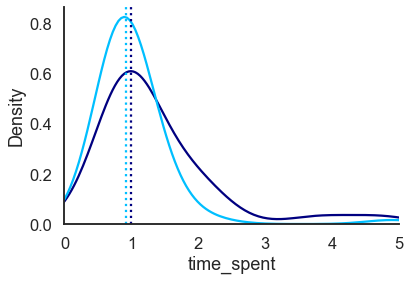

In [87]:
sample_stim =firsts[firsts['stim_condition']=='1.0']
ctrl_sample = sample_stim[sample_stim['group']=='CTRL']
nphr_sample = sample_stim[sample_stim['group']=='NPHR']

sns.kdeplot(data=ctrl_sample, x='time_spent', color='navy')
sns.kdeplot(data=nphr_sample, x='time_spent', color='deepskyblue')
plt.axvline(ctrl_sample['time_spent'].median(), c='navy', linestyle='dotted')
plt.axvline(nphr_sample['time_spent'].median(), c='deepskyblue', linestyle='dotted')

plt.xlim([0,5])
sns.despine()